In [1]:
#Khai báo thư viện
import pandas as pd
import numpy as np #Xử lý dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta, timezone
from decimal import Decimal, ROUND_DOWN #Xử lý số thập 
import time

#XÂY DỰNG MÔ HÌNH LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential #Đầu vào
from tensorflow.keras.layers import LSTM #Học phụ thuộc
from tensorflow.keras.layers import Dense, Dropout #Tránh overfitting và đầu ra

from sklearn.preprocessing import MinMaxScaler #Chuẩn hóa dữ liệu
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score #Đánh giá hiệu suất

2025-09-03 17:44:57.813551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-03 17:44:58.131630: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-03 17:44:59.571339: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [4]:
df = pd.read_csv("Personal/uth/NNLT Python/CK_Python/BTCUSDT_15m_processed.csv") 
print(df.head())

             open_time    Open     High      Low    Close    Volume  Year  \
0  2017-08-17 08:45:00  4360.7  4360.70  4360.69  4360.69  0.031285  2017   
1  2017-08-17 09:00:00  4360.0  4360.00  4360.00  4360.00  0.006296  2017   
2  2017-08-17 09:15:00  4360.0  4360.00  4360.00  4360.00  2.288705  2017   
3  2017-08-17 09:30:00  4360.0  4445.78  4360.00  4436.51  8.410800  2017   
4  2017-08-17 09:45:00  4444.0  4444.00  4444.00  4444.00  0.057822  2017   

        MA20      RSI14  
0  4319.2215  58.335040  
1  4324.1475  65.875549  
2  4329.0750  61.623309  
3  4335.3970  70.964059  
4  4342.1555  77.414035  


In [5]:
df = df[df['Year'] >= 2025]
print(df.shape)
print(df.tail())

(22210, 9)
                  open_time       Open       High        Low      Close  \
280228  2025-08-20 07:15:00  113722.84  113837.93  113720.86  113720.87   
280229  2025-08-20 07:30:00  113720.87  113720.87  113588.00  113612.01   
280230  2025-08-20 07:45:00  113612.01  113672.74  113432.00  113490.13   
280231  2025-08-20 08:00:00  113490.14  113609.94  113401.00  113609.94   
280232  2025-08-20 08:15:00  113609.94  113854.34  113609.93  113854.33   

           Volume  Year         MA20      RSI14  
280228   91.20673  2025  113581.3400  59.885407  
280229  127.34973  2025  113593.8795  50.157108  
280230  124.31949  2025  113596.4715  44.318596  
280231  119.43721  2025  113607.8475  52.546550  
280232  186.23173  2025  113620.0785  58.255708  


In [6]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'RSI14']

## hồi quy
y_price = df['Close'].shift(-1)
y_price = y_price.dropna()
X_price  = df[features].loc[y_price.index]

# phân loại
df['Close_MA12'] = df['Close'].rolling(window=12).mean()
df['Trend'] = (df['Close_MA12'].shift(-12) > df['Close_MA12']).astype(int)
y_trend = df['Trend'].dropna()
X_trend = df[features].loc[y_trend.index]


print("Shape hồi quy:", X_price.shape, y_price.shape)
print(y_price.head())
print("Shape phân loại:", X_trend.shape, y_trend.shape)
print(y_trend.value_counts())  # Kiểm tra phân bố nhãn
print(y_trend.head())

Shape hồi quy: (22209, 7) (22209,)
258023    93761.90
258024    93885.01
258025    94401.14
258026    94153.05
258027    93825.86
Name: Close, dtype: float64
Shape phân loại: (22210, 7) (22210,)
Trend
1    11435
0    10775
Name: count, dtype: int64
258023    0
258024    0
258025    0
258026    0
258027    0
Name: Trend, dtype: int64


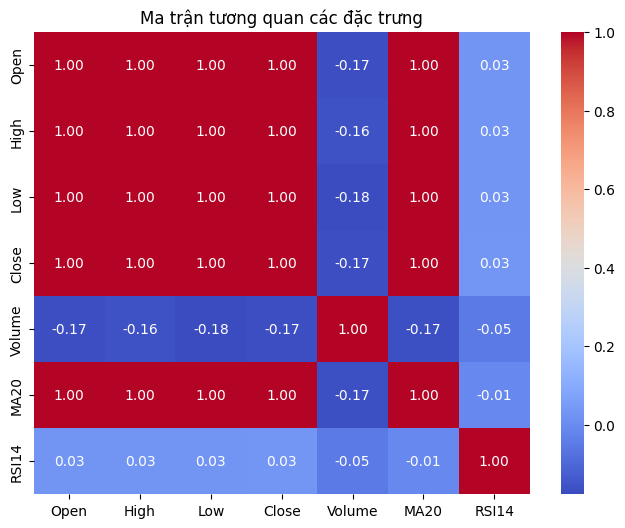

=== Ma trận tương quan ===
            Open      High       Low     Close    Volume      MA20     RSI14
Open    1.000000  0.999875  0.999868  0.999794 -0.168192  0.998960  0.025425
High    0.999875  1.000000  0.999773  0.999885 -0.159677  0.998880  0.027582
Low     0.999868  0.999773  1.000000  0.999883 -0.177093  0.998784  0.029063
Close   0.999794  0.999885  0.999883  1.000000 -0.168398  0.998783  0.030444
Volume -0.168192 -0.159677 -0.177093 -0.168398  1.000000 -0.165295 -0.050885
MA20    0.998960  0.998880  0.998784  0.998783 -0.165295  1.000000 -0.008916
RSI14   0.025425  0.027582  0.029063  0.030444 -0.050885 -0.008916  1.000000


In [7]:
#Phân tích tương quan
corr = df[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan các đặc trưng")
plt.show()

print("=== Ma trận tương quan ===")
print(corr)

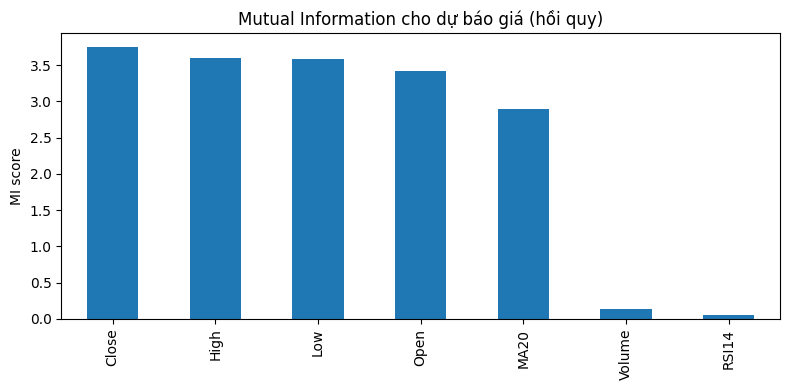

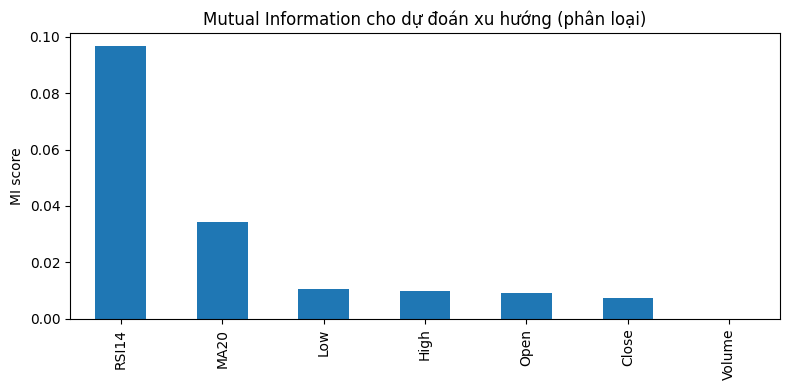


=== Shapes ===
X_price: (22209, 7)  y_price: (22209,)
X_trend: (22210, 7)  y_trend: (22210,)

=== MI cho dự báo giá (Close[t+1]) ===
Close     3.749718
High      3.593554
Low       3.576742
Open      3.422731
MA20      2.895316
Volume    0.135215
RSI14     0.054958
dtype: float64

=== MI cho dự đoán xu hướng (Trend) ===
RSI14     0.096576
MA20      0.034294
Low       0.010724
High      0.009784
Open      0.009240
Close     0.007316
Volume    0.000000
dtype: float64


In [10]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
# Mutual Information (MI)

# MI cho hồi quy
mi_price = mutual_info_regression(X_price.values, y_price.values, random_state=42)
mi_price_series = pd.Series(mi_price, index=features).sort_values(ascending=False)

# MI cho phân loại
y_trend = y_trend.astype(int)# chuyển lại int 0/1
mi_trend = mutual_info_classif(X_trend.values, y_trend.values, random_state=42)
mi_trend_series = pd.Series(mi_trend, index=features).sort_values(ascending=False)

# Vẽ biểu đồ MI
plt.figure(figsize=(8,4))
mi_price_series.plot(kind='bar')
plt.title("Mutual Information cho dự báo giá (hồi quy)")
plt.ylabel("MI score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
mi_trend_series.plot(kind='bar')
plt.title("Mutual Information cho dự đoán xu hướng (phân loại)")
plt.ylabel("MI score")
plt.tight_layout()
plt.show()

print("\n=== Shapes ===")
print("X_price:", X_price.shape, " y_price:", y_price.shape)
print("X_trend:", X_trend.shape, " y_trend:", y_trend.shape)

print("\n=== MI cho dự báo giá (Close[t+1]) ===")
print(mi_price_series)

print("\n=== MI cho dự đoán xu hướng (Trend) ===")
print(mi_trend_series)

In [12]:
#Đánh lại nhãn

# Các đặc trưng đã chọn
features_reg = ['Open', 'High', 'Low', 'Close','Volume','MA20']  # cho hồi quy
features_cls = ['RSI14', 'MA20', 'Close']  # cho phân loại

#Nhãn cho hồi quy (dự báo Close[t+1])
y_price = df['Close'].shift(-1).dropna()
X_price = df[features_reg].loc[y_price.index]

#Nhãn cho phân loại (xu hướng tăng/giảm)
df['Close_MA12'] = df['Close'].rolling(window=12).mean()
df['Trend'] = (df['Close_MA12'].shift(-12) > df['Close_MA12']).astype(int)
y_trend = df['Trend'].dropna()
X_trend = df[features_cls].loc[y_trend.index]

In [13]:
# Chia tập theo tỷ lệ
split_ratio = 0.8
split_idx_price = int(len(X_price) * split_ratio)
split_idx_trend = int(len(X_trend) * split_ratio)

# Hồi quy
X_train_reg, X_test_reg = X_price[:split_idx_price], X_price[split_idx_price:]
y_train_reg, y_test_reg = y_price[:split_idx_price], y_price[split_idx_price:]

# Phân loại
X_train_cls, X_test_cls = X_trend[:split_idx_trend], X_trend[split_idx_trend:]
y_train_cls, y_test_cls = y_trend[:split_idx_trend], y_trend[split_idx_trend:]

print("Bộ Train/Test hồi quy:")
print(X_train_reg.shape, y_train_reg.shape, X_test_reg.shape, y_test_reg.shape)

print("\nBộ Train/Test phân loại:")
print(X_train_cls.shape, y_train_cls.shape, X_test_cls.shape, y_test_cls.shape)
print(y_trend.value_counts())  

Bộ Train/Test hồi quy:
(17767, 6) (17767,) (4442, 6) (4442,)

Bộ Train/Test phân loại:
(17768, 3) (17768,) (4442, 3) (4442,)
Trend
1    11435
0    10775
Name: count, dtype: int64


In [14]:
#Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# scaler cho hồi quy
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled  = scaler_reg.transform(X_test_reg)

scaler_y = MinMaxScaler(feature_range=(0,1))
y_train_reg_scaled = scaler_y.fit_transform(y_train_reg.values.reshape(-1,1)).ravel()
y_test_reg_scaled  = scaler_y.transform(y_test_reg.values.reshape(-1,1)).ravel()

#scaler cho phân loại
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled  = scaler_cls.transform(X_test_cls)

In [7]:
#Xây dựng mô hình LSTM

In [15]:
# Tạo bộ dữ liệu dạng sliding window
def create_sequences_reg(X, y, timesteps=32):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps-1])  
    return np.array(Xs), np.array(ys)

def create_sequences_cls(X, y, timesteps=96):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps-1]) 
    return np.array(Xs), np.array(ys)

In [16]:
# Hồi quy
X_train_reg_seq, y_train_reg_seq = create_sequences_reg(X_train_reg_scaled, y_train_reg_scaled)
X_test_reg_seq, y_test_reg_seq = create_sequences_reg(X_test_reg_scaled, y_test_reg_scaled)

# Phân loại
X_train_cls_seq, y_train_cls_seq = create_sequences_cls(X_train_cls_scaled, y_train_cls.values)
X_test_cls_seq, y_test_cls_seq = create_sequences_cls(X_test_cls_scaled, y_test_cls.values)

print("Bộ dữ liệu hồi quy:", X_train_reg_seq.shape, y_train_reg_seq.shape, X_test_reg_seq.shape, y_test_reg_seq.shape)
print("Bộ dữ liệu phân loại:", X_train_cls_seq.shape, y_train_cls_seq.shape, X_test_cls_seq.shape, y_test_cls_seq.shape)

Bộ dữ liệu hồi quy: (17735, 32, 6) (17735,) (4410, 32, 6) (4410,)
Bộ dữ liệu phân loại: (17672, 96, 3) (17672,) (4346, 96, 3) (4346,)


In [17]:
# Callback EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
callbacks = [early_stop, reduce_lr]

In [18]:
# Xây dựng mô hình LSTM cho hồi quy
tf.keras.backend.clear_session()
from tensorflow.keras.optimizers import Adam

model_reg = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_reg_seq.shape[1], X_train_reg_seq.shape[2])),
    Dropout(0.3),  
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  
])

model_reg.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])
model_reg.summary()

E0000 00:00:1756899005.059697   33013 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1756899005.150174   33013 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/bush/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,641 (471.25 KB)

 Trainable params: 120,641 (471.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
  # Huấn luyện mô hình dự báo giá
  tf.keras.backend.clear_session()
  start_time = time.time()

  history_reg = model_reg.fit(
      X_train_reg_seq, y_train_reg_seq,
      validation_data=(X_test_reg_seq, y_test_reg_seq),
      epochs=200, batch_size=64,
      shuffle=False,
      callbacks=callbacks,
      verbose=1
  )

  end_time = time.time()
  print(f"Thời gian huấn luyện: {end_time - start_time:.2f} giây")

Epoch 1/200
278/278 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0942 - mae: 0.2281 - val_loss: 0.0103 - val_mae: 0.0909 - learning_rate: 1.0000e-04
Epoch 2/200
278/278 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0145 - mae: 0.0873 - val_loss: 0.0133 - val_mae: 0.1043 - learning_rate: 1.0000e-04
Epoch 3/200
278/278 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0053 - mae: 0.0529 - val_loss: 0.0112 - val_mae: 0.0953 - learning_rate: 1.0000e-04
Epoch 4/200
278/278 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0024 - mae: 0.0369 - val_loss: 0.0090 - val_mae: 0.0852 - learning_rate: 1.0000e-04
Epoch 5/200
278/278 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0013 - mae: 0.0271 - val_loss: 0.0090 - val_mae: 0.0852 - learning_rate: 1.0000e-04
Epoch 6/200
278/278 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 9.2213e-04 - mae: 0.0231 - val_loss: 0.0086 - val_mae: 0.0834 - learning_rate: 1.0000e-04
Epoch 7/200
278/278 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 8.3843e-04 - mae: 0.0219 - val_loss: 0.0090 - 

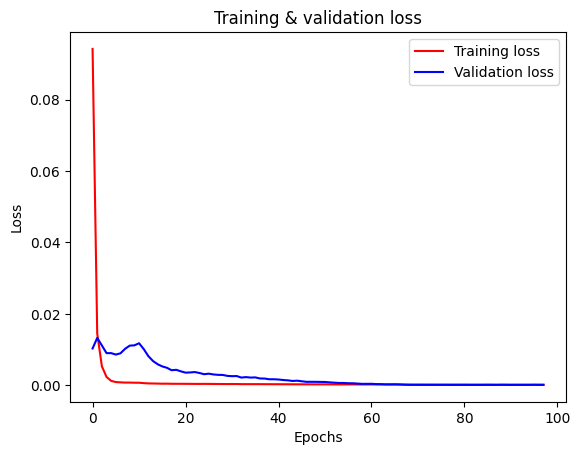

In [20]:
#Biểu đồ Loss qua các Epoch
loss = history_reg.history['loss']
val_loss = history_reg.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

In [21]:
from keras.saving import save_model
save_model(model_reg, "model_reg_0903_001.keras")

In [22]:
# inverse_transform dự báo để so sánh trên thang đo gốc:
y_pred_scaled = model_reg.predict(X_test_reg_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_reg_seq.reshape(-1,1))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [23]:
# Tính các metric
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# In kết quả
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 167996.99
RMSE: 409.87
MAE: 294.18
R²: 0.98


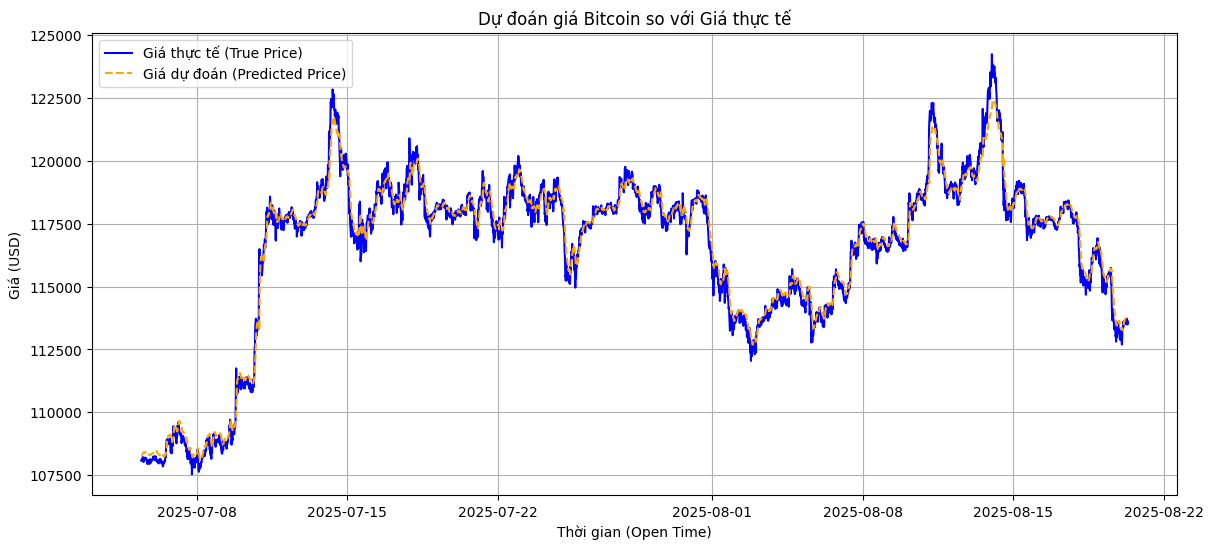

In [24]:
#Vẽ biểu đồ
test_dates = df.loc[y_price.index[-len(y_true):], 'open_time'].reset_index(drop=True)

results = pd.DataFrame({
    'Date': pd.to_datetime(test_dates),
    'True': y_true.flatten(),
    'Predicted': y_pred.flatten()
})

plt.figure(figsize=(14, 6))
plt.plot(results['Date'],y_true, label='Giá thực tế (True Price)', color='blue')
plt.plot(results['Date'],y_pred, label='Giá dự đoán (Predicted Price)', color='orange', linestyle='--')

plt.title('Dự đoán giá Bitcoin so với Giá thực tế')
plt.xlabel('Thời gian (Open Time)')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True)
plt.show()

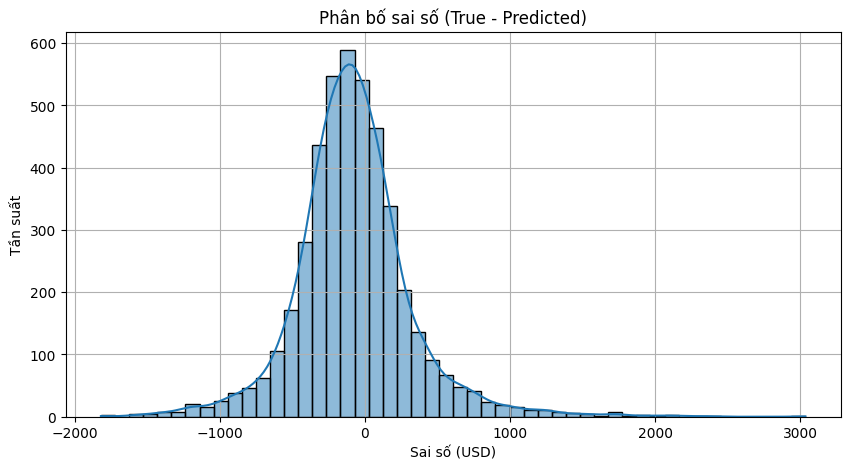

In [25]:
# Phân bố sai số
errors = y_true.flatten() - y_pred.flatten()
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=50, kde=True)
plt.title('Phân bố sai số (True - Predicted)')
plt.xlabel('Sai số (USD)')
plt.ylabel('Tần suất')
plt.grid(True)
plt.show()

In [56]:
# Xây dựng mô hình LSTM cho phân loại
from tensorflow.keras.optimizers import Adam


model_cls = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_cls_seq.shape[1], X_train_cls_seq.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # đầu ra xác suất [0,1]
])

model_cls.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_cls.summary()

/home/bush/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 96, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,105 (465.25 KB)

 Trainable params: 119,105 (465.25 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Huấn luyện mô hình phân loại
tf.keras.backend.clear_session()
start_time = time.time()

history_cls = model_cls.fit(
    X_train_cls_seq, y_train_cls_seq,
    validation_data=(X_test_cls_seq, y_test_cls_seq),
    epochs=150, batch_size=64,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
print(f"Thời gian huấn luyện: {end_time - start_time:.2f} giây")

Epoch 1/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.5405 - loss: 0.6861 - val_accuracy: 0.5796 - val_loss: 0.6792 - learning_rate: 1.0000e-04
Epoch 2/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.5875 - loss: 0.6745 - val_accuracy: 0.5601 - val_loss: 0.6759 - learning_rate: 1.0000e-04
Epoch 3/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.6060 - loss: 0.6657 - val_accuracy: 0.5527 - val_loss: 0.6774 - learning_rate: 1.0000e-04
Epoch 4/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.6183 - loss: 0.6552 - val_accuracy: 0.5449 - val_loss: 0.6864 - learning_rate: 1.0000e-04
Epoch 5/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.6380 - loss: 0.6413 - val_accuracy: 0.5465 - val_loss: 0.7049 - learning_rate: 1.0000e-04
Epoch 6/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.6474 - loss: 0.6326 - val_accuracy: 0.5798 - val_loss: 0.6710 - learning_rate: 2.0000e-05
Epoch 7/150
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 7

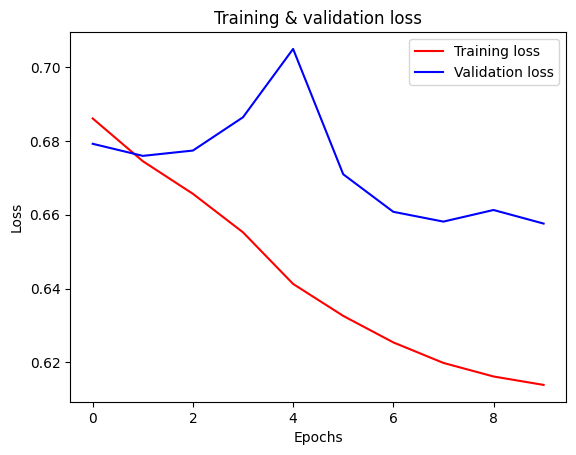

<Figure size 640x480 with 0 Axes>

In [58]:
#Biểu đồ Loss qua các Epoch
loss = history_cls.history['loss']
val_loss = history_cls.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.figure()

plt.show()

In [59]:
#Sử dụng classification_report từ scikit-learn để tính precision, recall, và F1-score:
from sklearn.metrics import classification_report
y_pred_cls = (model_cls.predict(X_test_cls_seq) > 0.5).astype(int)
print(classification_report(y_test_cls_seq, y_pred_cls))

136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
              precision    recall  f1-score   support

           0       0.54      0.84      0.66      2080
           1       0.70      0.34      0.46      2266

    accuracy                           0.58      4346
   macro avg       0.62      0.59      0.56      4346
weighted avg       0.62      0.58      0.55      4346



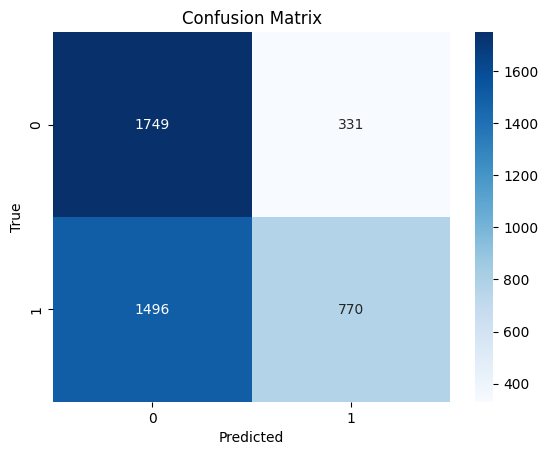

In [60]:
#Vẽ confusion matrix để kiểm tra phân bố dự đoán:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_cls_seq, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()